In [1]:
import os
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.tools as tls #visualization
import plotly.figure_factory as ff #visualization
from plotly.offline import init_notebook_mode, plot,iplot

# from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering
# from sklearn.neighbors import kneighbors_graph
from sklearn import (manifold, decomposition)

init_notebook_mode(connected=True)

datadir = os.path.join('.','data2020', 'players_20.csv')

# Curación

## Curacion de los datos (variables de soporte)

Explicacion de las [features](https://www.fifauteam.com/fifa-20-attributes-guide/)

In [2]:
#######################################################################
cols2keep_obj = list()
cols2keep_num = list()

# Features generales
cols2keep_obj.append('short_name')
cols2keep_obj.append('club')
cols2keep_obj.append('player_positions')
cols2keep_obj.append('preferred_foot')
cols2keep_obj.append('team_position')

cols2keep_num.append('height_cm')
cols2keep_num.append('weight_kg')
cols2keep_num.append('overall')
cols2keep_num.append('work_rate')
cols2keep_num.append('shooting')
cols2keep_num.append('passing')
cols2keep_num.append('dribbling')
cols2keep_num.append('defending')
cols2keep_num.append('physic')

# Features relativas a un arquero
cols2keep_num.append('goalkeeping_diving')
cols2keep_num.append('goalkeeping_handling')
cols2keep_num.append('goalkeeping_kicking')
cols2keep_num.append('goalkeeping_reflexes')
cols2keep_num.append('goalkeeping_positioning')

# Features relativas a la capacidad de ataque
cols2keep_num.append('attacking_crossing')
cols2keep_num.append('attacking_finishing')
cols2keep_num.append('attacking_heading_accuracy')
cols2keep_num.append('attacking_short_passing')
cols2keep_num.append('attacking_volleys')

# Features relativas a las habilidades
cols2keep_num.append('skill_moves')
cols2keep_num.append('skill_dribbling')
cols2keep_num.append('skill_curve')
cols2keep_num.append('skill_fk_accuracy')
cols2keep_num.append('skill_long_passing')
cols2keep_num.append('skill_ball_control')

# Features relativas a la movilidad
cols2keep_num.append('movement_acceleration')
cols2keep_num.append('movement_sprint_speed')
cols2keep_num.append('movement_agility')
cols2keep_num.append('movement_reactions')
cols2keep_num.append('movement_balance')

# Features relativas a la potencia
cols2keep_num.append('power_shot_power')
cols2keep_num.append('power_jumping')
cols2keep_num.append('power_stamina')
cols2keep_num.append('power_strength')
cols2keep_num.append('power_long_shots')

# Features relativas a las soft skills
cols2keep_num.append('mentality_aggression')
cols2keep_num.append('mentality_interceptions')
cols2keep_num.append('mentality_positioning')
cols2keep_num.append('mentality_vision')
cols2keep_num.append('mentality_penalties')
cols2keep_num.append('mentality_composure')

# Features relativas a la defensa
cols2keep_num.append('defending_marking')
cols2keep_num.append('defending_standing_tackle')
cols2keep_num.append('defending_sliding_tackle')

#######################################################################
# Columnas con campos en NaN
cols2fix = list()
cols2fix.append('shooting')
cols2fix.append('passing')
cols2fix.append('dribbling')
cols2fix.append('defending')
cols2fix.append('physic')

# Regla de transformacion de work_rate
regla = dict()
regla['High/High'] = 4
regla['High/Medium'] = 3
regla['High/Low'] = 2
regla['Medium/High'] = 1 
regla['Medium/Medium'] = 0
regla['Medium/Low'] = -1
regla['Low/High'] = -2
regla['Low/Medium'] = -3
regla['Low/Low'] = -4

## Curación de los datos (ejecución)

In [9]:
#1. Cargamos el conjunto de datos fifa 2020
dfn = pd.read_csv(datadir)
dfn = dfn.sample(n=4000)

#2. Tomamos la metadata que nos interesa `cols2keep_obj` 
dfo = dfn[cols2keep_obj]

#3. Tomamos solo las columnas que nos interesan `cols2keep_num`
dfn = dfn[cols2keep_num]

#4. Se completan con cero las entradas de las columnas `cols2fix` para remover los NaN
dfn[cols2fix] = dfn[cols2fix].fillna(0)

#5. Se completan con "Undef" las entradas de la columna `team_position` para remover los NaN
dfn['work_rate'] = dfn.work_rate.apply(lambda x: regla[x])

#6. S convierte `work_rate` a categorica numérica en el rango [-4, 4]
dfo['team_position'] = dfo.team_position.fillna('Undef')

display(dfo.info())
display('####################')
display(dfn.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 12489 to 7881
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   short_name        4000 non-null   object
 1   club              4000 non-null   object
 2   player_positions  4000 non-null   object
 3   preferred_foot    4000 non-null   object
 4   team_position     4000 non-null   object
dtypes: object(5)
memory usage: 187.5+ KB


None

'####################'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 12489 to 7881
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   height_cm                   4000 non-null   int64  
 1   weight_kg                   4000 non-null   int64  
 2   overall                     4000 non-null   int64  
 3   work_rate                   4000 non-null   int64  
 4   shooting                    4000 non-null   float64
 5   passing                     4000 non-null   float64
 6   dribbling                   4000 non-null   float64
 7   defending                   4000 non-null   float64
 8   physic                      4000 non-null   float64
 9   goalkeeping_diving          4000 non-null   int64  
 10  goalkeeping_handling        4000 non-null   int64  
 11  goalkeeping_kicking         4000 non-null   int64  
 12  goalkeeping_reflexes        4000 non-null   int64  
 13  goalkeeping_positioning     4

None

In [10]:
dfo.head(5)

,short_name,club,player_positions,preferred_foot,team_position
12489,C. Pérez,Alianza Petrolera,CB,Right,SUB
13405,L. Malagón,Monarcas Morelia,GK,Right,RES
12452,Fran Vieites,RC Celta,GK,Right,RES
12068,A. Stølås,FK Haugesund,"LB, LM",Left,RES
1736,M. Wolf,Borussia Dortmund,"RB, RM, CM",Right,SUB


In [11]:
dfn.head(5)

,height_cm,weight_kg,overall,work_rate,shooting,passing,dribbling,defending,physic,goalkeeping_diving,...,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle
12489,185,79,63,0,25.0,44.0,42.0,63.0,65.0,15,...,23,58,56,21,32,34,54,64,65,60
13405,179,77,62,0,0.0,0.0,0.0,0.0,0.0,63,...,6,27,13,4,28,14,42,15,10,14
12452,186,79,63,0,0.0,0.0,0.0,0.0,0.0,65,...,9,28,14,6,50,11,42,10,14,14
12068,182,75,64,3,68.0,66.0,68.0,57.0,69.0,8,...,68,58,57,58,68,59,55,51,63,60
1736,188,81,75,3,70.0,73.0,76.0,68.0,77.0,12,...,67,73,69,74,74,52,72,69,67,67


In [12]:
time_start = time.time()

tsne = manifold.TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000, n_jobs=2)
X_tsne = tsne.fit_transform(dfn)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.021s...
[t-SNE] Computed neighbors for 4000 samples in 0.651s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 14.822282
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.232147
[t-SNE] KL divergence after 1000 iterations: 1.576755
t-SNE done! Time elapsed: 24.240458011627197 seconds


In [14]:
X_tsne[3990:4000]

array([[-17.124863 ,  30.376574 ],
       [ 40.913445 ,  14.236159 ],
       [ 56.108574 , -38.007156 ],
       [ 49.309475 , -34.553066 ],
       [ 24.754902 ,  41.98399  ],
       [-23.805676 ,  22.842346 ],
       [-44.60627  ,  22.695992 ],
       [ 34.909435 ,  31.470789 ],
       [ 31.1489   ,   1.3126744],
       [-12.5878935, -17.839636 ]], dtype=float32)

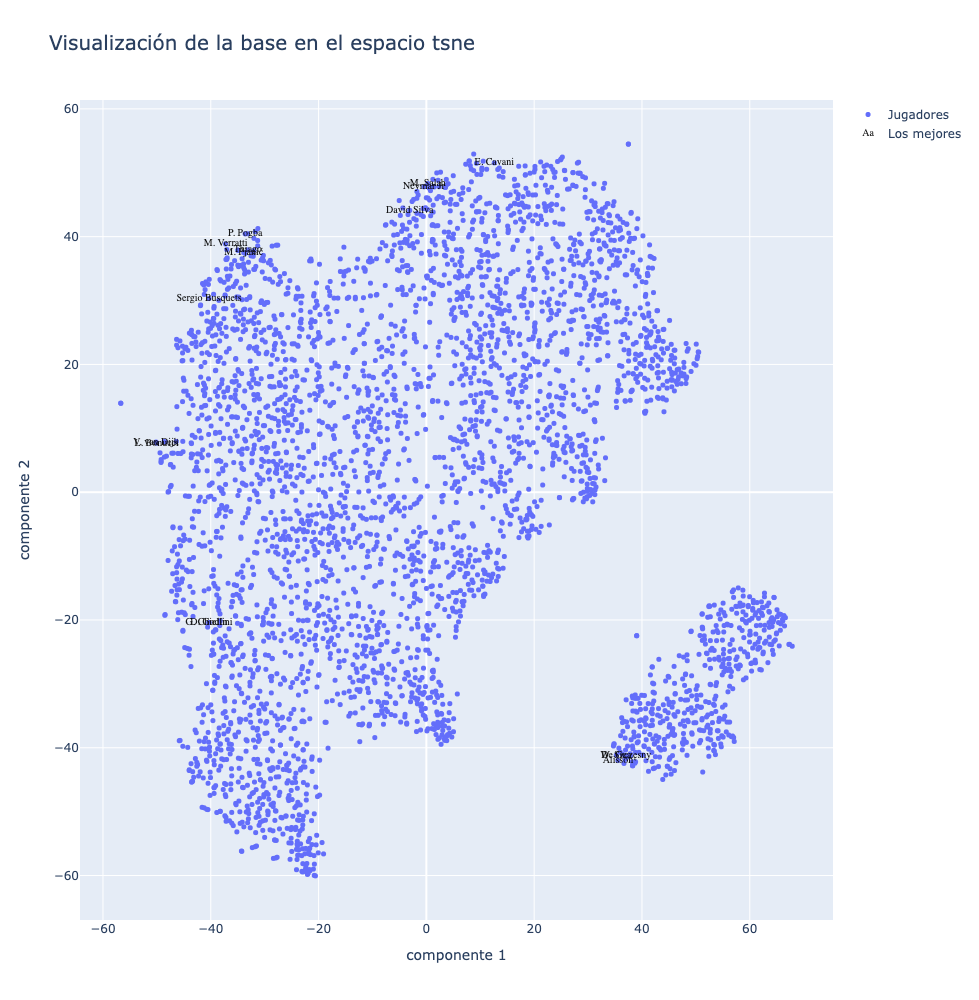

In [23]:
data=[]
bool_crack=dfn.overall > 85

#graficamos los datos en el espacio transformado: las dos componentes tsne

graf1 = go.Scatter(x=X_tsne[:,0], y=X_tsne[:,1],
                   name='Jugadores',
                   mode='markers',
                   text=dfo[['club', 'team_position']].apply(lambda x:f'{x.club} - {x.team_position}', axis=1),
                   marker=dict(size=5))

crack =go.Scatter(x=X_tsne[bool_crack,0], y=X_tsne[bool_crack,1],
                  name='Los mejores',
                  text=dfo.loc[bool_crack,'short_name'],
                  textfont=dict(family='sans serif',size=10,color='black'),
                  opacity=0.9,
                  mode='text')

data=[graf1, crack]

layout = go.Layout(title="Visualización de la base en el espacio tsne",titlefont=dict(size=20),
                   xaxis=dict(title='componente 1'),
                   yaxis=dict(title='componente 2'),
                   autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)
# plot(fig)

In [33]:
dfo[['short_name','player_positions', 'team_position']]

,short_name,player_positions,team_position
12489,C. Pérez,CB,SUB
13405,L. Malagón,GK,RES
12452,Fran Vieites,GK,RES
12068,A. Stølås,"LB, LM",RES
1736,M. Wolf,"RB, RM, CM",SUB
...,...,...,...
13797,Liu Jian,CB,SUB
643,B. Davies,"LB, LWB",SUB
4130,O. Estupiñán,ST,SUB
18044,A. El-Youssef,"RM, ST",RES


In [116]:
def pos_tranf(pp, tp):
    forwards = set(['RF', 'ST', 'LW', 'LF', 'RS', 'LS', 'RM', 'LM','RW'])
    midfielders = set(['RCM','LCM','LDM','CAM','CDM','LAM','RDM','CM','RAM','CF'])
    defenders = set(['RCB','CB','LCB','LB','RB','RWB','LWB'])
    goalkeepers = set(['GK'])
    
    tocheck = set(pp) | set(tp)
    
    if  tocheck & forwards:
        return 'Forward'
    
    elif tocheck & midfielders:
        return 'Midfielder'
    
    elif tocheck & defenders:
        return 'Defender'
    
    elif tocheck & goalkeepers:
        return 'GoalKeeper'
    
    else:
        return 'NaN'

In [117]:
dfo['position'] = dfo.apply(lambda x: pos_tranf(x.player_positions.split(', '), x.team_position.split(', ')), axis=1)
display(dfo.head(10))
display(dfo.position.value_counts())

,short_name,club,player_positions,preferred_foot,team_position,position
12489,C. Pérez,Alianza Petrolera,CB,Right,SUB,Defender
13405,L. Malagón,Monarcas Morelia,GK,Right,RES,GoalKeeper
12452,Fran Vieites,RC Celta,GK,Right,RES,GoalKeeper
12068,A. Stølås,FK Haugesund,"LB, LM",Left,RES,Forward
1736,M. Wolf,Borussia Dortmund,"RB, RM, CM",Right,SUB,Forward
13623,J. Medina,América de Cali,"RM, RW, ST",Right,SUB,Forward
3016,E. Alfonso,Brescia,GK,Right,SUB,GoalKeeper
14298,M. Khalfan,Al Ain FC,LM,Right,SUB,Forward
14008,W. Singo,Torino,CB,Right,SUB,Defender
13425,M. Sykes,Oxford United,CM,Right,SUB,Midfielder


Forward       1542
Defender      1046
Midfielder     959
GoalKeeper     453
Name: position, dtype: int64

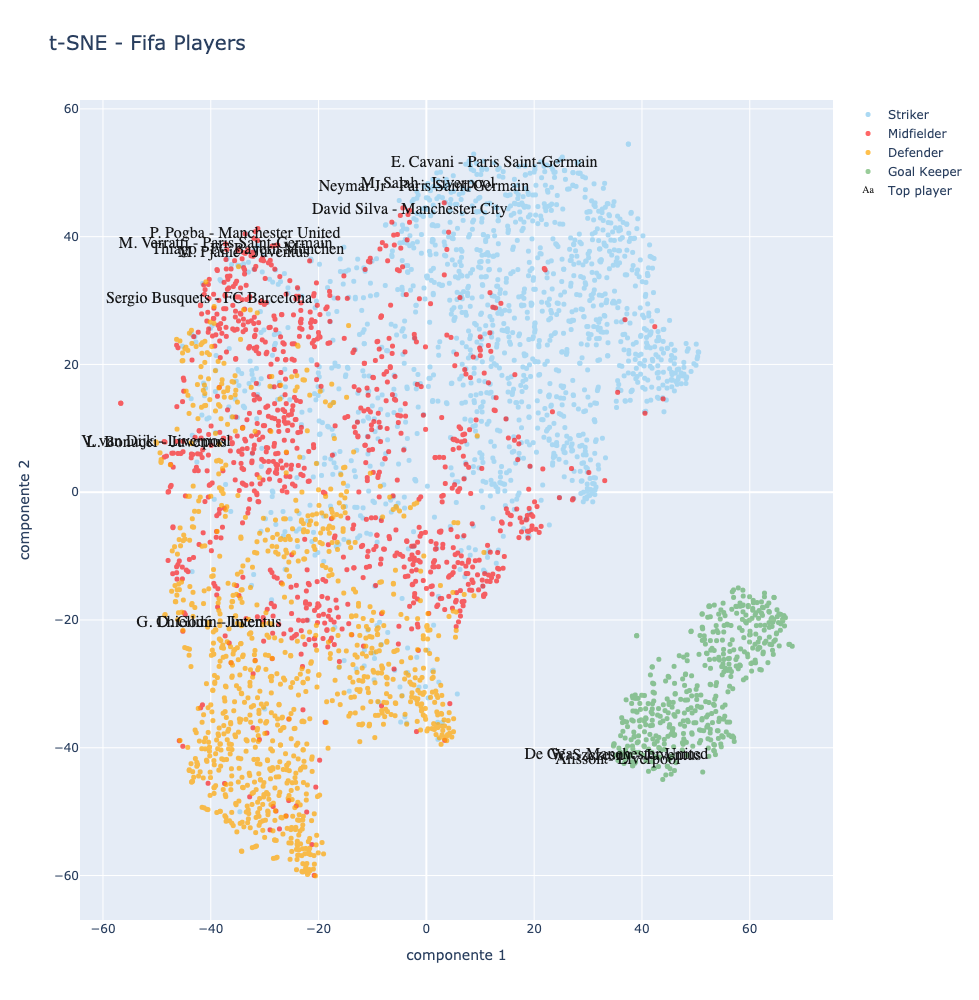

In [118]:
bool_striker = dfo["position"] == 'Forward'
bool_midfielder = dfo["position"] == 'Midfielder'
bool_defender = dfo["position"] == 'Defender'
bool_gk = dfo["position"] == 'GoalKeeper'

bool_crack=dfn["overall"] > 85

palette=['navy','red','#A2D5F2','orange','green','pink']  

striker = go.Scatter(x=X_tsne[bool_striker,0], y=X_tsne[bool_striker,1],
                    name='Striker',
                    text=dfo.loc[bool_striker, ['club', 'short_name']].apply(lambda x:f'{x.short_name} - {x.club}', axis=1),
                    opacity=0.9,
                    marker=dict(color=palette[2],size=5),
                    mode='markers')

midfielder = go.Scatter(x=X_tsne[bool_midfielder,0], y=X_tsne[bool_midfielder,1],
                       name='Midfielder',
                       text=dfo.loc[bool_midfielder, ['club', 'short_name']].apply(lambda x:f'{x.short_name} - {x.club}', axis=1),
                       opacity=0.6,
                       marker=dict(color=palette[1],size=5),
                       mode='markers')

defender = go.Scatter(x=X_tsne[bool_defender,0], y=X_tsne[bool_defender,1],
                     name='Defender',
                     text=dfo.loc[bool_defender, ['club', 'short_name']].apply(lambda x:f'{x.short_name} - {x.club}', axis=1),
                     opacity=0.7,
                     marker=dict(color=palette[3],size=5),
                     mode='markers')

gk = go.Scatter(x=X_tsne[bool_gk,0], y=X_tsne[bool_gk,1],
                name='Goal Keeper',
                text=dfo.loc[bool_gk, ['club', 'short_name']].apply(lambda x:f'{x.short_name} - {x.club}', axis=1),
                opacity=0.4,
                marker=dict(color=palette[4],size=5),
                mode='markers')

crack = go.Scatter(x=X_tsne[bool_crack,0], y=X_tsne[bool_crack,1],
                   name='Top player',
                   text=dfo.loc[bool_crack, ['club', 'short_name']].apply(lambda x:f'{x.short_name} - {x.club}', axis=1),
                   textfont=dict(family='sans serif',color='black',size=16),
                   opacity=0.9,
                   mode='text')

data=[striker,midfielder,defender,gk,crack]

layout = go.Layout(title="t-SNE - Fifa Players", 
                   titlefont=dict(size=20),
                   xaxis=dict(title='componente 1'),
                   yaxis=dict(title='componente 2'),
                   autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)
# plot(fig)